
# Simulation, Photometry and Analysis of Star Profiles for CASTOR 

### Steps

1. **Add Star in the Form of a Delta Function**
    - Implement a delta function to represent a star.
  
2. **Include IPC to Simulate Blurring of Delta Function**
    - Introduce Inter-Pixel Capacitance (IPC) to simulate blurring.
    

3. **Generate Profile and Fit with Gaussian to Measure Sigma and FWHM**
    - Generate the profile and fit it with a Gaussian function.
  

4. **Convolve with Honeywell PSFs (in FITS Format)**
    - Convolve the profile with provided Honeywell Point Spread Functions (PSFs).

5. **Generate Profile and Fit with Gaussian to Measure Sigma and FWHM (Post-PSF Convolution)**
    - Repeat the profile generation and Gaussian fitting steps.


6. **Convolve with Second Gaussian to Simulate Telescope Jitter**
    

In [2]:
import pyxel

In [3]:
config = pyxel.load("point_source.yaml")

exposure = config.exposure
detector = config.detector
pipeline = config.pipeline

result = pyxel.run_mode(
    mode=exposure,
    detector=detector,
    pipeline=pipeline,
)

result

Readout time:   0%|          | 0/3 [00:00<?, ?it/s]

DataTree('None', parent=None)
│   Dimensions:  (time: 3, y: 255, x: 255)
│   Coordinates:
│     * time     (time) float64 24B 1.0 5.0 7.0
│     * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 247 248 249 250 251 252 253 254
│     * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 247 248 249 250 251 252 253 254
│   Data variables:
│       photon   (time, y, x) float64 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
│       charge   (time, y, x) float64 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
│       pixel    (time, y, x) float64 2MB 0.0005329 0.0002588 ... 0.0005203 0.001071
│       signal   (time, y, x) float64 2MB 5.329e-08 2.588e-08 ... 1.071e-07
│       image    (time, y, x) uint16 390kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
│   Attributes:
│       pyxel version:  2.0
│       running mode:   Exposure
├── DataTree('scene')
└── DataTree('data')

#### Step 3

Just trying to factor in the interpixel capacitance with weak coupling using pyxel


In [4]:
pyxel.display_detector(detector)

BokehModel(combine_events=True, render_bundle={'docs_json': {'e15343d0-006f-4f57-89ed-b06bed8104b5': {'version…

### Now the Goal is to get the clipped region and plot along the axes, we expect to get a delta function, which we do.

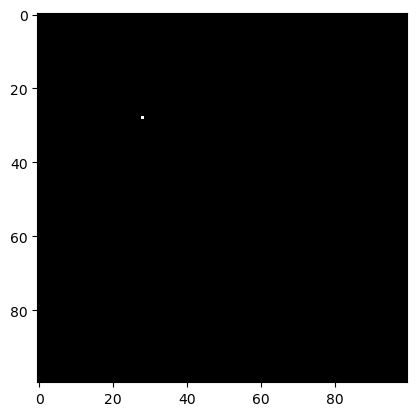

199.77910585549168


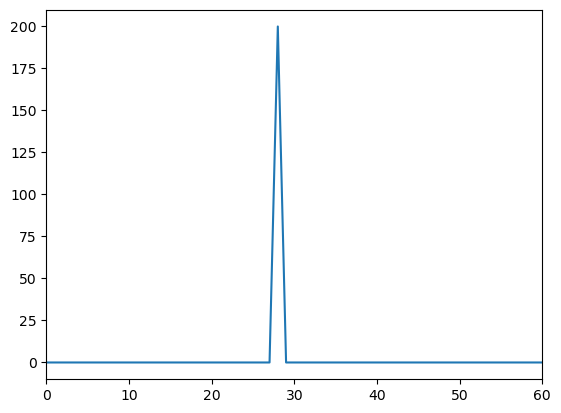

In [15]:
photon=result["photon"].to_numpy()
clip=photon[2][100:200,100:200]

import matplotlib.pyplot as plt
plt.imshow(clip, cmap='gray')
plt.show()

print(clip.sum())
# plot the photon count along the clipped region
plt.plot(clip.sum(axis=0))
plt.xlim(0,60)
plt.show()


### Convolve with Honeywell's PSF

First we view what the Honeywell PSF looks like in the FITS file


Note that the fftconvolve function is used to convolve the PSF with the data. For more details, Visit [the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html)


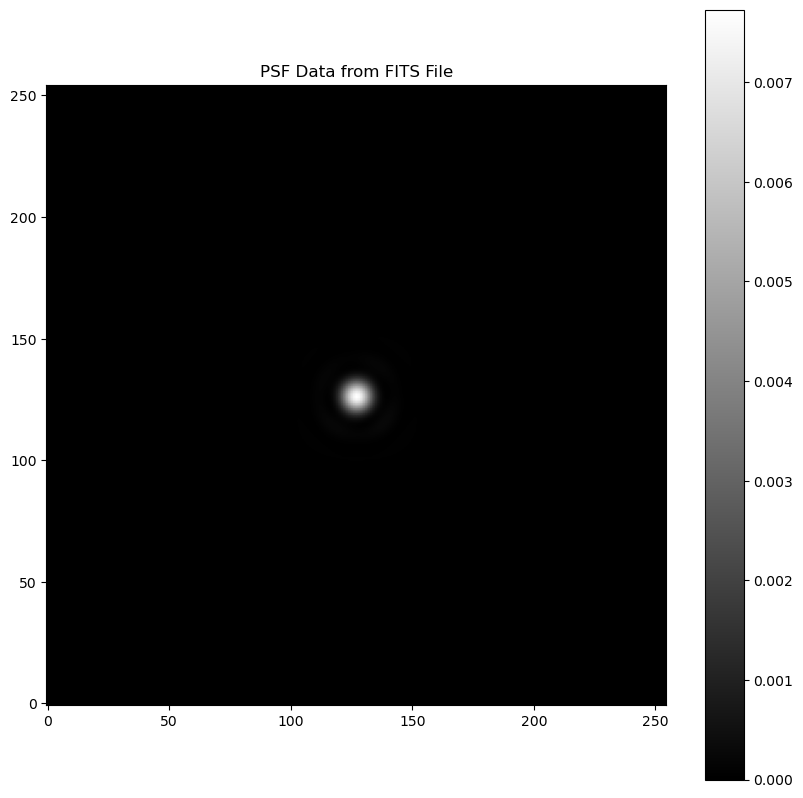

(255, 255)

In [6]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

psf_filename = '/Users/wasi/Downloads/Gsamples_median_withJitter_X00-000d_Y00-000d_S0-001mm.fits'
hdu_list = fits.open(psf_filename)
psf_data = hdu_list[0].data
hdu_list.close()

# Display the PSF data
plt.figure(figsize=(10, 10))
plt.imshow(psf_data, cmap='gray', origin='lower')
plt.colorbar()
plt.title('PSF Data from FITS File')
plt.show()

psf_data.shape


<h2> Convolution </h2>

### This is where I think the problem is right now. The issue seems to be with how I am convolving/resizing things. Notice how the colorbar values are significantly different. The PSF data is on the order of $(10^{-3})$, while the delta function is on the order of $(10^{2})$ in magnitude. This discrepancy results in units for the convolved data ranging from $(10^{-1}$) to $(10^{0}$).


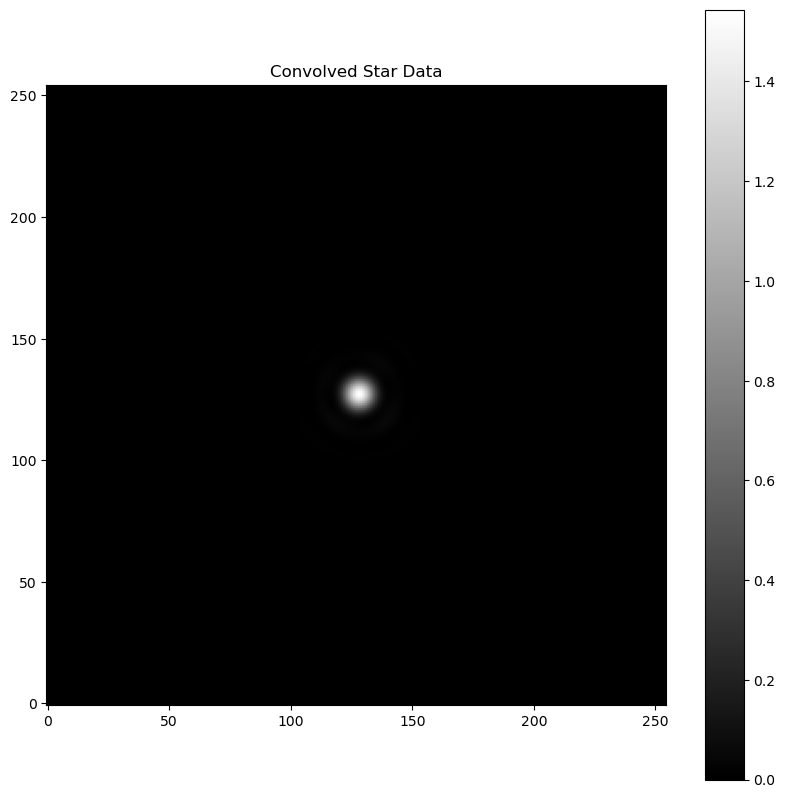

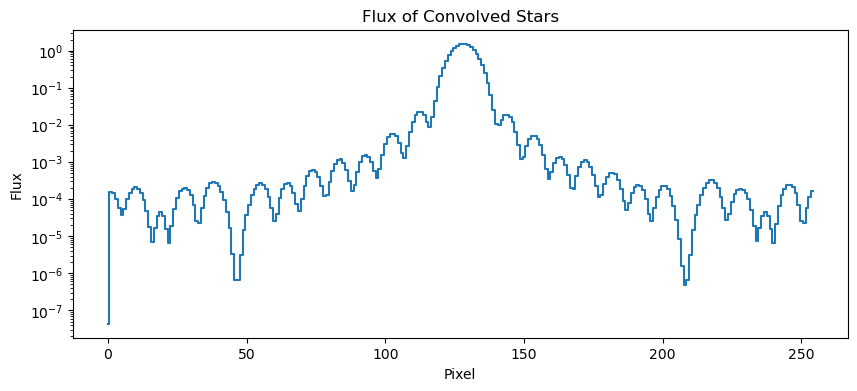

In [10]:
snaps=result["photon"].sel(time=7)
# psf_data is of the shape (255, 255) and snaps is of the shape (450,450) so we must resize the psf_data to the shape of snaps
# resize the snaps to the shape of psf_data
from scipy.ndimage import zoom
snaps = zoom(snaps, (psf_data.shape[0] / snaps.shape[0], psf_data.shape[1] / snaps.shape[1]), order=3)

convolved_data = fftconvolve(snaps, psf_data, mode='same')
convolved_filename = '/Users/wasi/DeSC/convolved_u.fits'
hdu = fits.PrimaryHDU(convolved_data)
hdu.writeto(convolved_filename, overwrite=True)

# Display the convolved image data
plt.figure(figsize=(10, 10))
plt.imshow(convolved_data, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Convolved Star Data')
plt.show()

# Plot the flux of the stars along the central row
center = convolved_data.shape[0] // 2
plt.figure(figsize=(10, 4))
flux = convolved_data[center, :]
plt.plot(flux, drawstyle='steps-mid')
plt.yscale('log')
plt.xlabel('Pixel')
plt.ylabel('Flux')
plt.title('Flux of Convolved Stars')
plt.show()


# Gaussian Fit

### Made the units fit. Remember that the pyxel model assumes a detector pixel/arcsec rate of 0.01


Fitted parameters: a = 1.5669653483953, b = 51.151730903324236, c = 5.875891309594284


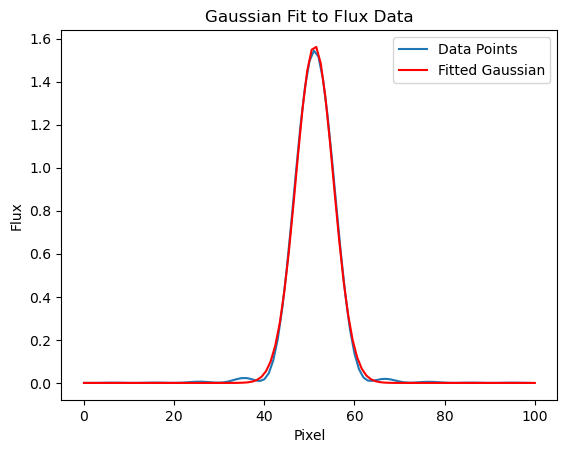

FWHM: 0.14 arcseconds


In [13]:

import numpy as np
from scipy.optimize import curve_fit

def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) / c) ** 2)

# Cut the flux data to the central 100 pixels
flux_cut = flux[center - 50:center + 50]

# Fit the flux data to a Gaussian
x = np.arange(len(flux_cut))
initial_guess = [max(flux_cut), np.argmax(flux_cut), 10]
popt, pcov = curve_fit(gaussian, x, flux_cut, p0=initial_guess)
a, b, c = popt
print(f"Fitted parameters: a = {a}, b = {b}, c = {c}")

# Plot the flux data and the fitted Gaussian
x_fit = np.linspace(0, len(flux_cut), 100)
y_fit = gaussian(x_fit, *popt)
plt.plot(x, flux_cut, label='Data Points')
plt.plot(x_fit, y_fit, label='Fitted Gaussian', color='red')
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Flux')
plt.title('Gaussian Fit to Flux Data')
plt.show()

# Full width at half maximum (FWHM) of the Gaussian
fwhm = (2 * np.sqrt(2 * np.log(2)) * c)*0.01 # Convert to arcseconds

print(f"FWHM: {fwhm:.2f} arcseconds")

In [14]:
print(f"FWHM: {fwhm:.2f} arcseconds")

FWHM: 0.14 arcseconds
